In [ ]:
# imports

# utils
import pandas as pd
import numpy as np
import cv2
import os
import joblib
import time
import itertools
from tqdm import tqdm
import numbers
from math import isnan
import random
import cv2

# plots
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# tensorflow & scikitlearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score


from sklearn.model_selection import train_test_split
import time

In [ ]:
# determine seed 
SEED = 1994
np.random.seed(SEED)
tf.random.set_seed(SEED)

# params
dataset_url = "https://drive.google.com/file/d/1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp/view"
dataset_dir_name = "lfw2/lfw2"
data_split_xls_path = "splitted_data.xls"

VALIDATION_FRAC = 0.2

In [ ]:
# download the dataset
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp" -O LFW-a && rm -rf /tmp/cookies.txt
!unzip -q LFW-a && rm LFW-a

In [ ]:
# download train & test txt files
!wget http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt
!wget http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt

--2022-05-17 09:48:03--  http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56579 (55K) [text/plain]
Saving to: ‘pairsDevTrain.txt’

pairsDevTrain.txt   100%[===================>]  55.25K   122KB/s    in 0.5s    

2022-05-17 09:48:04 (122 KB/s) - ‘pairsDevTrain.txt’ saved [56579/56579]

--2022-05-17 09:48:05--  http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26002 (25K) [text/plain]
Saving to: ‘pairsDevTest.txt’

pairsDevTest.txt    100%[===================>]  25.39K   114KB/s    in 0.2s    

2022-05-17 09:48:05 (114 KB/s) - ‘pairsDevTest.txt’ saved [26002/2

# Read the dataset, split into train, test and validation sets

In [ ]:
def preprocess_dataset_names(df):
  # preprocess dataset
  df = df.rename(columns={0:"Name1", 1:"ID1", 2:"Name2", 3:"ID2"})
  df = df.iloc[1: , :] # drop first row since it has only a number in it
  df["ID2"] = df.apply(lambda x: x["Name2"] if isnan(x["ID2"]) else x["ID2"], axis=1)
  df["Name2"] = df.apply(lambda x: x["Name1"] if (x["Name2"]).isnumeric() else x["Name2"], axis=1)
  df["target"] = df.apply(lambda x: 1 if x["Name1"] == x["Name2"] else 0 , axis=1) # "same"=0; "different"=1

  return df

def load_dataset_names(dataset_txt_path):
  # Loop the data lines
  with open(dataset_txt_path, 'r') as temp_f:
      # get No of columns in each line
      col_count = [ len(l.split("\t")) for l in temp_f.readlines() ]

  # Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
  column_names = [i for i in range(0, max(col_count))]

  # Read csv
  df = pd.read_csv(dataset_txt_path, header=None, delimiter="\t", names=column_names)

  df = preprocess_dataset_names(df)

  return df

In [ ]:
def get_image_path(name, id):
  # Returns the path of a single person's image
  return f'{dataset_dir_name}/{name}/{name}_{str(id).rjust(4, "0")}.jpg'

def load_image(image_path):
  # Reads and returns an image
  return cv2.imread(image_path)

def normalize_image(img):
  # Normalize the input inage to values in a range of [0,1] and resizes it
  img = img/255.
  img = (cv2.resize(img, (105, 105)))

  return img

def read_image(name, id):
  # Read, load and normalize a single image
  img_path = get_image_path(name, id)
  img = load_image(img_path)
  img = normalize_image(img)

  return img

def read_data(df):
  #  load and normalize all images of the same data portion.
      # return: train_x1 - numpy array of images
              # train_x2 - numpy array of images
              # y_labels - list of labels (0 for "same person", 1 otherwise)
              
  train_x1, train_x2 = [], [] #first list- 1st image , second list - 2nd image
  y_labels = []
  for _ , row in df.iterrows():
      img1 = read_image(row["Name1"].strip(), int(row['ID1'])) 
      train_x1.append(img1)
      img2 = read_image(row["Name2"], int(row['ID2'])) 
      train_x2.append(img2)
      y_labels.append(row["target"])

  return np.array(train_x1), np.array(train_x2), np.array(y_labels)


In [ ]:
test_names_df = load_dataset_names("pairsDevTest.txt")
train_val_names_df = load_dataset_names("pairsDevTrain.txt")
train_names_df, val_names_df = train_test_split(train_val_names_df, test_size=VALIDATION_FRAC, stratify=train_val_names_df["target"])

train_x1, train_x2, train_y = read_data(train_names_df)
val_x1, val_x2, val_y = read_data(val_names_df)
test_x1, test_x2, test_y = read_data(test_names_df)

# Exploratory data analysis

In [ ]:
# find the size of the dataset
classes_list = os.listdir(dataset_dir_name)
print(f"number of classes (number of different people): {len(classes_list)}")

# find the number of total examples
total_examples_num = [len(os.listdir(f'{dataset_dir_name}/{name}')) for name in classes_list]
print(f"number of total examples: {np.sum(total_examples_num)}")
print(f"average number of images per a person:{np.mean(total_examples_num):.3f} +- {np.std(total_examples_num):.3f}")

number of classes (number of different people): 5749
number of total examples: 13233
average number of images per a person:2.302 +- 9.016


In [ ]:
# distribution of images per a person
fig = px.histogram(total_examples_num, marginal="rug",  title="Distribution of number of images per person",
                   labels={"count": "Number of people", "value": "number of images"})
fig.show()

In [ ]:
# get the size of train, test and validation subsets
print(f"size of train set:{train_x1.shape}, size of validation set: {val_x1.shape}, size of test set:{test_x1.shape}")

size of train set:(1936, 105, 105, 3), size of validation set: (440, 105, 105, 3), size of test set:(1000, 105, 105, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 0, '0: different person; 1: same person')

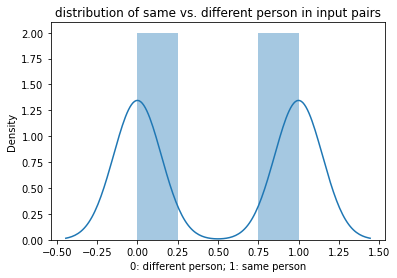

In [ ]:
sns.distplot(pd.concat([val_names_df], ignore_index=True)["target"])
plt.title("distribution of same vs. different person in input pairs")
plt.xlabel("0: different person; 1: same person")

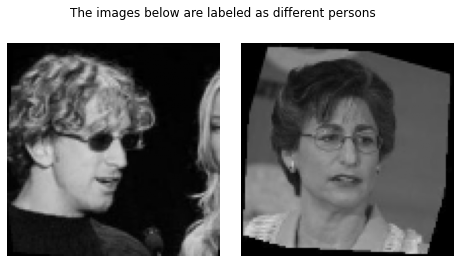

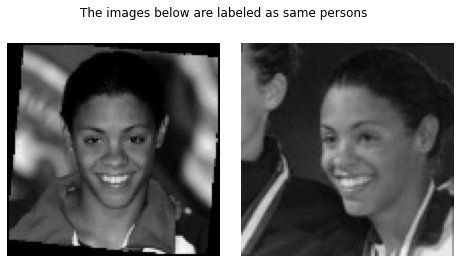

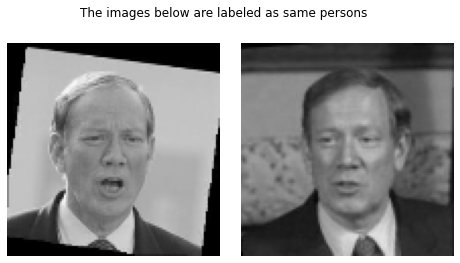

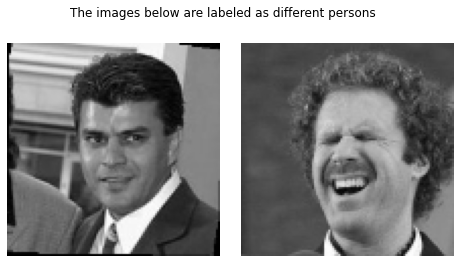

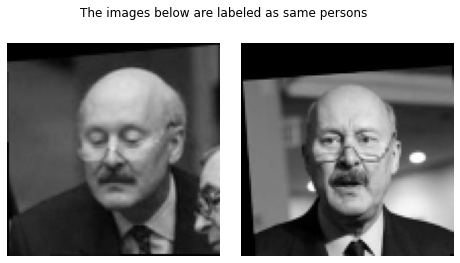

In [ ]:
# plot samples of the dataset
def plot_twin_images(img1, img2, label):
  label = 'same' if label==1 else 'different'
  fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(8,8))
  fig.subplots_adjust(hspace=0.1, wspace=0.1)
  fig.suptitle(f'The images below are labeled as {label} persons', y=0.75)
 
  for i, img in enumerate([img1, img2]):
    ax[i].axis('off')
    ax[i].imshow(img)
 
def plot_data_samples(data_x1, data_x2, y, n_samples):
 samples_idx = random.sample(range(*y.shape), n_samples)
 
 for idx in samples_idx:
    plot_twin_images(data_x1[idx], data_x2[idx], y[idx])

plot_data_samples(train_x1, train_x2, train_y, 5)


# Implementation of a siamies network

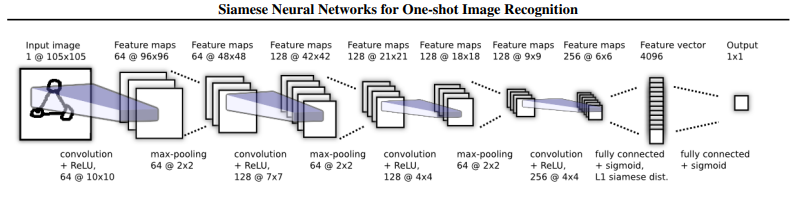

In [ ]:
# basic twin tetwork as described in the paper
def get_twin_network(name,dropout=0.2, conv1_w_b=('glorot_uniform', 'zeros')):
  inp = keras.layers.Input(shape=(105, 105, 3))
  twin = keras.layers.Conv2D(64, (10, 10), activation='relu', name=name+'_conv1',kernel_initializer=conv1_w_b[0], bias_initializer=conv1_w_b[1])(inp)
  twin = keras.layers.MaxPooling2D(name=name+'_max_pooling1')(twin)
  twin = keras.layers.Conv2D(128, (7, 7), activation='relu',  name=name+'_conv2',kernel_initializer=conv1_w_b[0], bias_initializer=conv1_w_b[1])(twin)
  twin = keras.layers.MaxPooling2D(name=name+'_max_pooling2')(twin)
  twin = keras.layers.Conv2D(128, (4, 4), activation='relu',  name=name+'_conv3',kernel_initializer=conv1_w_b[0], bias_initializer=conv1_w_b[1])(twin)
  twin = keras.layers.MaxPooling2D(name=name+'_max_pooling3')(twin)
  twin = keras.layers.Conv2D(256, (4, 4), activation='relu', name=name+'_conv4',kernel_initializer=conv1_w_b[0], bias_initializer=conv1_w_b[1])(twin)
  twin = keras.layers.Flatten(name=name+'_flatten')(twin)
  twin = keras.layers.Dense(4096, activation='sigmoid', name=name+'_dense')(twin)
  return Model(inp, twin, name='twin_model')


In [ ]:
get_twin_network('twin').summary()

Model: "twin_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 105, 105, 3)]     0         
                                                                 
 twin_conv1 (Conv2D)         (None, 96, 96, 64)        19264     
                                                                 
 twin_max_pooling1 (MaxPooli  (None, 48, 48, 64)       0         
 ng2D)                                                           
                                                                 
 twin_conv2 (Conv2D)         (None, 42, 42, 128)       401536    
                                                                 
 twin_max_pooling2 (MaxPooli  (None, 21, 21, 128)      0         
 ng2D)                                                           
                                                                 
 twin_conv3 (Conv2D)         (None, 18, 18, 128)       2

In [ ]:
# imporoved twin - we added batch normalization after every convolution and dropout after every max pooling - to try and avoid overfitting
def get_improved_twin_network(name,dropout=0.2, conv1_w_b=('glorot_uniform', 'zeros')):
  inp = keras.layers.Input(shape=(105, 105, 3))
  twin = keras.layers.Conv2D(64, (10, 10), activation='relu', name=name+'_conv1',kernel_initializer=conv1_w_b[0], bias_initializer=conv1_w_b[1])(inp)
  twin = keras.layers.BatchNormalization()(twin)
  twin = keras.layers.MaxPooling2D(name=name+'_max_pooling1')(twin)
  twin = keras.layers.Dropout(dropout)(twin)
  twin = keras.layers.Conv2D(128, (7, 7), activation='relu',  name=name+'_conv2',kernel_initializer=conv1_w_b[0], bias_initializer=conv1_w_b[1])(twin)
  twin = keras.layers.BatchNormalization()(twin)
  twin = keras.layers.MaxPooling2D(name=name+'_max_pooling2')(twin)
  twin = keras.layers.Dropout(dropout)(twin)
  twin = keras.layers.Conv2D(128, (4, 4), activation='relu',  name=name+'_conv3',kernel_initializer=conv1_w_b[0], bias_initializer=conv1_w_b[1])(twin)
  twin = keras.layers.BatchNormalization()(twin)
  twin = keras.layers.MaxPooling2D(name=name+'_max_pooling3')(twin)
  twin = keras.layers.Dropout(dropout)(twin)
  twin = keras.layers.Conv2D(256, (4, 4), activation='relu', name=name+'_conv4',kernel_initializer=conv1_w_b[0], bias_initializer=conv1_w_b[1])(twin)
  twin = keras.layers.Flatten(name=name+'_flatten')(twin)
  twin = keras.layers.Dense(4096, activation='sigmoid', name=name+'_dense')(twin)
  return Model(inp, twin, name='twin_imporoved_model')

In [ ]:
get_improved_twin_network('imporoved').summary()

Model: "twin_imporoved_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 105, 105, 3)]     0         
                                                                 
 imporoved_conv1 (Conv2D)    (None, 96, 96, 64)        19264     
                                                                 
 batch_normalization_15 (Bat  (None, 96, 96, 64)       256       
 chNormalization)                                                
                                                                 
 imporoved_max_pooling1 (Max  (None, 48, 48, 64)       0         
 Pooling2D)                                                      
                                                                 
 dropout_18 (Dropout)        (None, 48, 48, 64)        0         
                                                                 
 imporoved_conv2 (Conv2D)    (None, 42, 42, 12

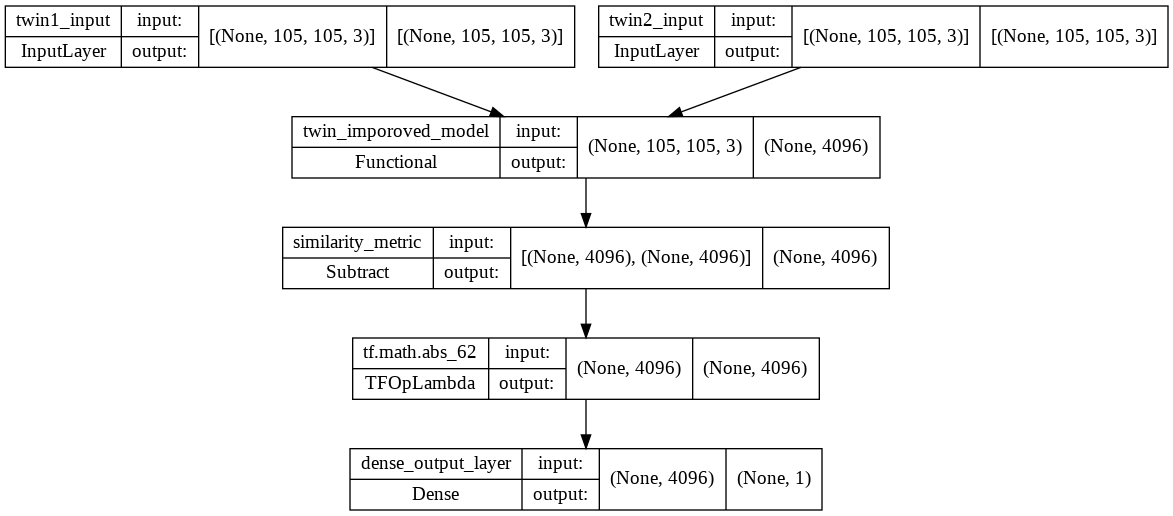

In [ ]:

def create_model(init_wehights=True,learning_rate=0.0001, dropout=0.2, l2=0.1):
  # maybe we should init new weights and bias for each conv layer?
  twin1_inp = keras.layers.Input(shape=(105, 105, 3), name='twin1_input')
  twin2_inp = keras.layers.Input(shape=(105, 105, 3), name='twin2_input')
  if init_wehights:
    W_init_conv1 = keras.initializers.RandomNormal(mean = 0.0, stddev = 1e-2)
    b_init_conv1 = keras.initializers.RandomNormal(mean = 0.5, stddev = 1e-2)
    weights = (W_init_conv1, b_init_conv1)
  else:
    weights = ('glorot_uniform', 'zeros')

  # twin_model = get_twin_network('twin', dropout, weights)
  twin_model = get_improved_twin_network('imporoved_twin', dropout, weights)

  twin1 = twin_model(twin1_inp)
  twin2 = twin_model(twin2_inp)

  L1_layer = keras.layers.Subtract(name='similarity_metric')([twin1, twin2])
  L1_layer = tf.math.abs(L1_layer)
  output = keras.layers.Dense(1, activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l2(l2), name='dense_output_layer')(L1_layer)

  model = Model(inputs=[twin1_inp, twin2_inp], outputs=output)
  # we used SGD optimizer as described in the paper
  model.compile(optimizer=SGD(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
  
  return model
model = create_model()
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [ ]:
# function to plot the accuracy and loss of train
def plot_loss_and_accuracy(history):
  fig, ax = plt.subplots(2, figsize=(10,10))
  ax[0].plot(history.history['accuracy'], label="train")
  ax[0].plot(history.history['val_accuracy'], label="val")
  ax[1].plot(history.history['loss'], label="train")
  ax[1].plot(history.history['val_loss'], label="val")
  ax[0].set_title('Accuracy')
  ax[1].set_title('Loss')
  plt.legend(loc='best')
  ax[0].set_ylim((0,1))
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[1].set_ylim((0,1))
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  
  plt.show()

In [ ]:
# function to plot miss classifications examples
test_x = [test_x1, test_x2]
def show_miss_clasifications(indexes, test_pred, test_pred_rnd, sample_amount=4):
  idx_sample = random.sample(indexes, sample_amount)

  for idx in idx_sample:
    color = 'green' if test_y[idx] == test_pred_rnd[idx] else 'red'
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4,4), facecolor=color)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    if test_y[idx]:
      title = f'{test_pred[idx]*100:.2f}% to be the same'
    else:
      title = f'{100 - test_pred[idx]*100:.2f}% to be the different'

    fig.suptitle(f'Predicted {title}', y=0.75)

    for i, axi in enumerate(ax):
      axi.imshow(test_x[i][idx])
      axi.axis('off')

Epoch 1/100
16/16 [==============================] - 5s 295ms/step - loss: 0.8953 - accuracy: 0.5026 - val_loss: 0.8952 - val_accuracy: 0.4659
Epoch 2/100
16/16 [==============================] - 4s 280ms/step - loss: 0.8951 - accuracy: 0.5062 - val_loss: 0.8951 - val_accuracy: 0.4659
Epoch 3/100
16/16 [==============================] - 5s 283ms/step - loss: 0.8950 - accuracy: 0.5057 - val_loss: 0.8949 - val_accuracy: 0.4659
Epoch 4/100
16/16 [==============================] - 5s 286ms/step - loss: 0.8949 - accuracy: 0.5057 - val_loss: 0.8948 - val_accuracy: 0.4705
Epoch 5/100
16/16 [==============================] - 5s 290ms/step - loss: 0.8947 - accuracy: 0.5036 - val_loss: 0.8947 - val_accuracy: 0.4705
Epoch 6/100
16/16 [==============================] - 5s 292ms/step - loss: 0.8946 - accuracy: 0.5031 - val_loss: 0.8945 - val_accuracy: 0.4727
Epoch 7/100
16/16 [==============================] - 5s 294ms/step - loss: 0.8945 - accuracy: 0.5041 - val_loss: 0.8944 - val_accuracy: 0.4682

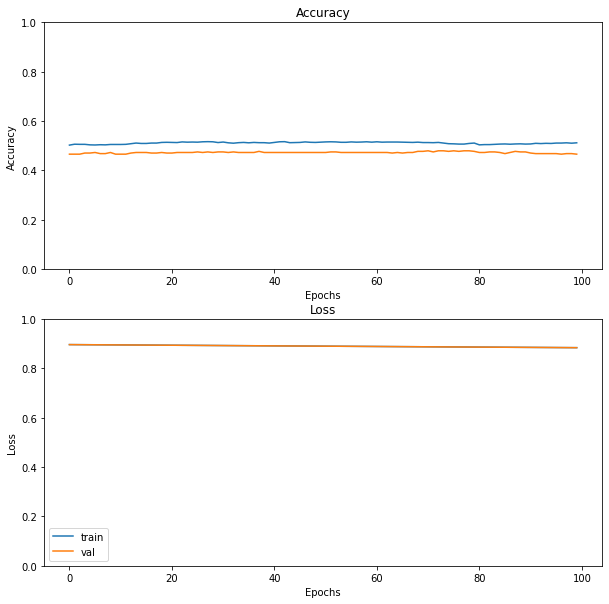

32/32 [==============================] - 1s 29ms/step - loss: 0.8828 - accuracy: 0.5000
Score:  [0.8827707767486572, 0.5]


In [ ]:
# create and evaluate basic model as described in the paper

model = create_model()
start_time = time.time()
history = model.fit([train_x1, train_x2], train_y, batch_size=128, epochs=100, validation_data=([val_x1, val_x2], val_y))
print("Run time in seconds: ", time.time()-start_time)	
plot_loss_and_accuracy(history)
test_pred = model.predict([test_x1, test_x2]).reshape(-1)
test_pred_rnd = np.around(test_pred)
print("Score: ", model.evaluate([test_x1, test_x2], test_y))

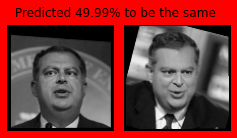

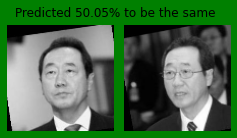

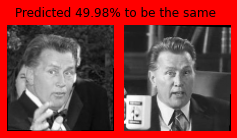

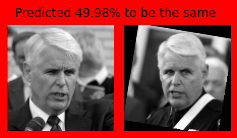

In [ ]:
# show predictions of same person:
show_miss_clasifications(range(int(test_y.shape[0]/2)), test_pred, test_pred_rnd)

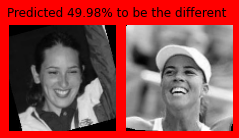

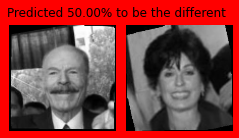

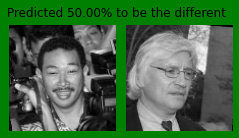

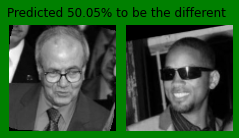

In [ ]:
# show predictions of different people:
show_miss_clasifications(range(int(test_y.shape[0]/2), int(test_y.shape[0])), test_pred, test_pred_rnd)

# Experiments

In [ ]:
# function to create and trian model with params dictionary
def train_model(params, x1, x2, y, x1_val, x2_val, y_val):
  start_time = time.time()
  model = create_model(init_wehights=False, learning_rate=params['lr'], dropout=params['do'], l2=params['l2'])
  history = model.fit((x1, x2), y, batch_size=params['bs'], epochs=params['e'], validation_data=([x1_val, x2_val], y_val))
  end_time = time.time()
  return model, history, end_time-start_time

In [ ]:
# experiment on different parameters
lr = [0.0001, 0.001, 0.01] # learning rate
dropout = [0.2, 0.5, 0.8] # dropout rate at the last layer
epochs = [40] 
batch_size = [64, 128, 256]
l2_reg = [0.1, 0.01]


combinations = list(itertools.product(lr, dropout, epochs, batch_size, l2_reg))
combinations_len = len(combinations)
keys = ['lr', 'do', 'e', 'bs', 'l2']
results = {}
for combination in combinations:
  params_dict = {keys[i]: combination[i] for i in range(len(combination))}
  print(params_dict)
  model, history, runtime = train_model(params_dict, train_x1, train_x2, train_y, val_x1, val_x2, val_y)
  print("Run time for model",params_dict, " in seconds: ", runtime)

  test_loss, test_acc = model.evaluate([test_x1, test_x2], test_y, verbose=0)
  val_loss, val_acc = model.evaluate([val_x1, val_x2], val_y, verbose=0)

  print(f"test loss: {test_loss}, test acuracy:{test_acc}")
  results[str(params_dict)] = (test_loss, test_acc,val_loss, val_acc, runtime)

results_df = pd.DataFrame(results)
results_df.to_csv('results.csv')

{'lr': 0.0001, 'do': 0.2, 'e': 40, 'bs': 64, 'l2': 0.1}
Epoch 1/40
28/28 [==============================] - 25s 342ms/step - loss: 0.8990 - accuracy: 0.4949 - val_loss: 0.8909 - val_accuracy: 0.5273
Epoch 2/40
28/28 [==============================] - 5s 167ms/step - loss: 0.8927 - accuracy: 0.5193 - val_loss: 0.8906 - val_accuracy: 0.5091
Epoch 3/40
28/28 [==============================] - 5s 167ms/step - loss: 0.8943 - accuracy: 0.5153 - val_loss: 0.8904 - val_accuracy: 0.5045
Epoch 4/40
28/28 [==============================] - 5s 167ms/step - loss: 0.8953 - accuracy: 0.5074 - val_loss: 0.8897 - val_accuracy: 0.5182
Epoch 5/40
28/28 [==============================] - 5s 168ms/step - loss: 0.8918 - accuracy: 0.5216 - val_loss: 0.8884 - val_accuracy: 0.5250
Epoch 6/40
28/28 [==============================] - 5s 168ms/step - loss: 0.8928 - accuracy: 0.5080 - val_loss: 0.8873 - val_accuracy: 0.5523
Epoch 7/40
28/28 [==============================] - 5s 168ms/step - loss: 0.8926 - accuracy

In [ ]:
# horizontal augmentation to the train set - to try to avoid overfitting
def augment_horizontal(data_x1, data_x2, y, n_samples):
  samples_idx = random.sample(range(*y.shape), n_samples)

  new_samples = [], [], []
  for idx in samples_idx:
    twin1_img, twin2_img, label = data_x1[idx], data_x2[idx], y[idx]
    flipped_twin1 = cv2.flip(twin1_img, 1)
    new_samples[0].append(flipped_twin1)
    new_samples[1].append(twin2_img)
    new_samples[2].append(label)
  
  return np.concatenate([data_x1,np.array(new_samples[0])]), np.concatenate([data_x2,np.array(new_samples[1])]), np.concatenate([y,np.array(new_samples[2])])

train_x1, train_x2, train_y = augment_horizontal(train_x1, train_x2, train_y, int(len(train_y)*0.1))
train_x1.shape

(1936, 105, 105, 3)

Epoch 1/100
31/31 [==============================] - 7s 189ms/step - loss: 0.7182 - accuracy: 0.5134 - val_loss: 0.7119 - val_accuracy: 0.5182
Epoch 2/100
31/31 [==============================] - 5s 177ms/step - loss: 0.7001 - accuracy: 0.5573 - val_loss: 0.7122 - val_accuracy: 0.5409
Epoch 3/100
31/31 [==============================] - 5s 177ms/step - loss: 0.6896 - accuracy: 0.5909 - val_loss: 0.7113 - val_accuracy: 0.5364
Epoch 4/100
31/31 [==============================] - 5s 177ms/step - loss: 0.6706 - accuracy: 0.6312 - val_loss: 0.7088 - val_accuracy: 0.5795
Epoch 5/100
31/31 [==============================] - 5s 178ms/step - loss: 0.6531 - accuracy: 0.6622 - val_loss: 0.6994 - val_accuracy: 0.6227
Epoch 6/100
31/31 [==============================] - 5s 177ms/step - loss: 0.6390 - accuracy: 0.6792 - val_loss: 0.6867 - val_accuracy: 0.6045
Epoch 7/100
31/31 [==============================] - 5s 177ms/step - loss: 0.6211 - accuracy: 0.6999 - val_loss: 0.6763 - val_accuracy: 0.5682

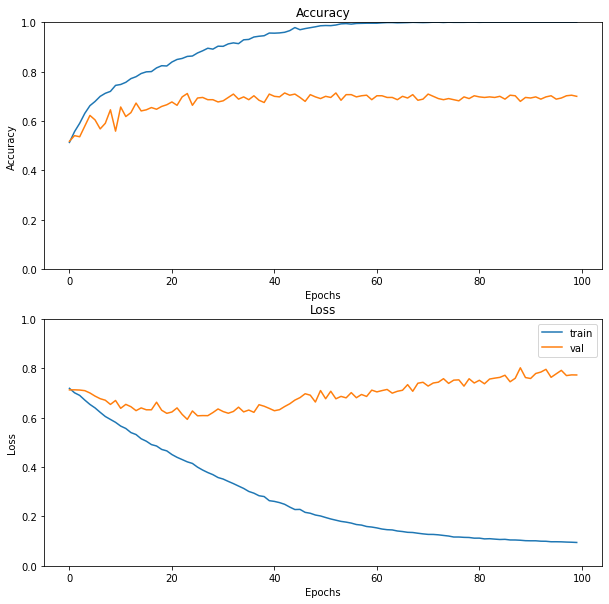

In [ ]:
# run best params model 100 epochs

best_params = {'lr': 0.01, 'e':100, 'do': 0.2, 'bs': 64, 'l2':0.01}
best_model, history, runtime = train_model(best_params, train_x1, train_x2, train_y, val_x1, val_x2, val_y)

print("Run time for model",best_params, " in seconds: ", runtime)
test_loss, test_acc = best_model.evaluate([test_x1, test_x2], test_y, verbose=0)
val_loss, val_acc = best_model.evaluate([val_x1, val_x2], val_y, verbose=0)
print(f"test loss: {test_loss}, test acuracy:{test_acc}")

plot_loss_and_accuracy(history)

In [ ]:
test_pred = best_model.predict([test_x1, test_x2]).reshape(-1)
test_pred_rnd = np.around(test_pred)

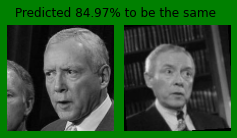

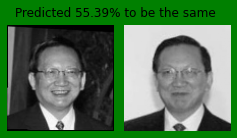

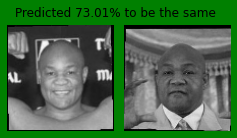

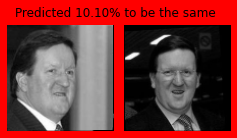

In [ ]:
# show predictions of same person:
show_miss_clasifications(range(int(test_y.shape[0]/2)), test_pred, test_pred_rnd)

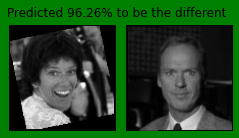

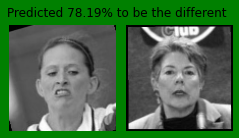

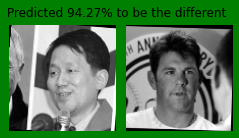

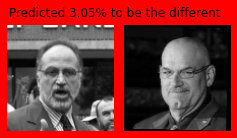

In [ ]:
# show predictions of different people:
show_miss_clasifications(range(int(test_y.shape[0]/2), int(test_y.shape[0])), test_pred, test_pred_rnd)